In [ ]:
import pandas as pd

# Load the Excel file
df = pd.read_excel('/content/Online Retail.xlsx')

# Check data structure
df.head()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [ ]:
# Remove missing CustomerIDs
df = df[df['CustomerID'].notnull()]

# Remove negative quantities and prices
df = df[(df['Quantity'] > 0) & (df['UnitPrice'] > 0)]

# Create TotalPrice
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']

In [ ]:
import datetime as dt

# Reference date is one day after the last invoice
ref_date = df['InvoiceDate'].max() + dt.timedelta(days=1)

# RFM aggregation
rfm = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (ref_date - x.max()).days,       # Recency
    'InvoiceNo': 'nunique',                                   # Frequency (distinct purchases)
    'TotalPrice': 'sum'                                       # Monetary
}).reset_index()

rfm.columns = ['CustomerID', 'Recency', 'Frequency', 'Monetary']
rfm.head()
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 397884 entries, 0 to 541908
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    397884 non-null  object        
 1   StockCode    397884 non-null  object        
 2   Description  397884 non-null  object        
 3   Quantity     397884 non-null  int64         
 4   InvoiceDate  397884 non-null  datetime64[ns]
 5   UnitPrice    397884 non-null  float64       
 6   CustomerID   397884 non-null  float64       
 7   Country      397884 non-null  object        
 8   TotalPrice   397884 non-null  float64       
dtypes: datetime64[ns](1), float64(3), int64(1), object(4)
memory usage: 30.4+ MB


In [ ]:
from sklearn.preprocessing import StandardScaler

# Scale only the RFM values
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm[['Recency', 'Frequency', 'Monetary']])

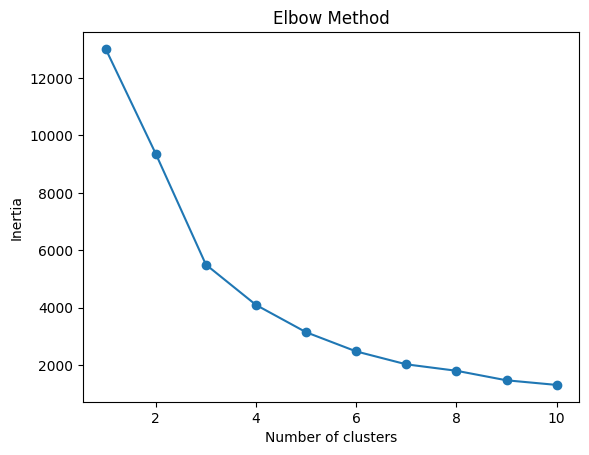

In [ ]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Elbow Method to determine optimal k
inertia = []
for k in range(1, 11):
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(rfm_scaled)
    inertia.append(km.inertia_)

# Plot the elbow curve
plt.plot(range(1, 11), inertia, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

In [ ]:
# Apply final KMeans
kmeans = KMeans(n_clusters=4, random_state=42)
rfm['Cluster'] = kmeans.fit_predict(rfm_scaled)

In [ ]:
rfm.groupby('Cluster').mean()

,CustomerID,Recency,Frequency,Monetary
Cluster,,,,
0,15289.128356,43.702685,3.682711,1359.049284
1,15347.791940,248.075914,1.552015,480.617480
2,15435.000000,7.384615,82.538462,127338.313846
3,15212.857843,15.500000,22.333333,12709.090490


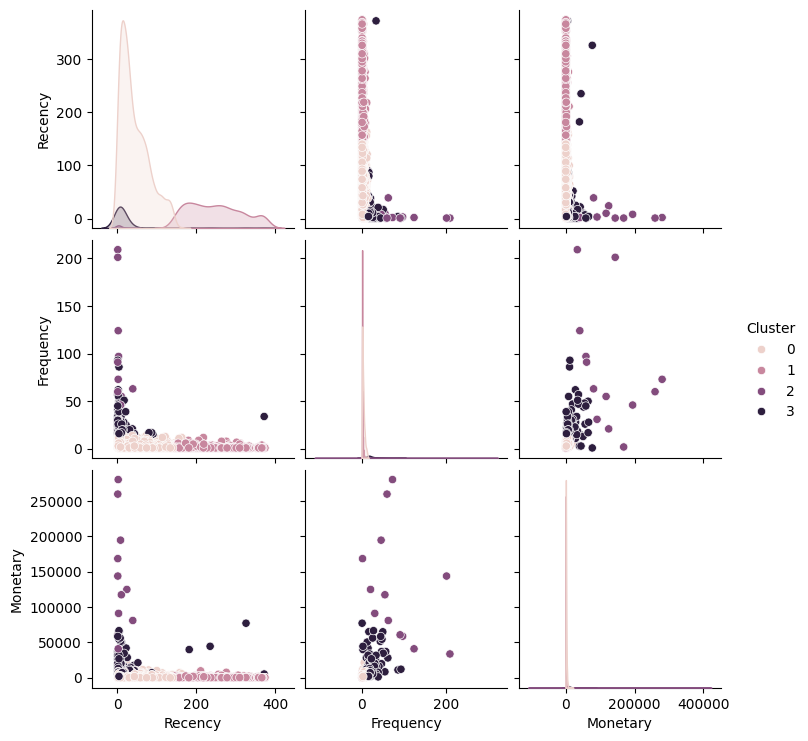

In [ ]:
import seaborn as sns
sns.pairplot(rfm, hue='Cluster', vars=['Recency', 'Frequency', 'Monetary'])